In [1]:
import sys
import torch
import time, os

folder_path = '../models/'
if folder_path not in sys.path:
    sys.path.append(folder_path)

from pemp import PEMP


torch.set_float32_matmul_precision('high')

def get_free_gpu():
    gpu_util = []
    for i in range(torch.cuda.device_count()):
        torch.cuda.set_device(i)  # Switch GPU
#        gpu_util.append((i, torch.cuda.memory_stats()['reserved_bytes.all.current'] / (1024 ** 2)))
        gpu_util.append((i, torch.cuda.utilization()))
    gpu_util.sort(key=lambda x: x[1])
    return gpu_util[0][0]

if torch.cuda.is_available():
    available_gpu = get_free_gpu()
    if available_gpu == 0:
        device = torch.device("cuda:0")
    else:
        device = torch.device(f"cuda:{available_gpu}")
else:
    device = torch.device("cpu")

print("Device :", device)

Device : cuda:0


In [2]:
dx, dy, dpe = 1, 1, 4
num_demos, num_val = 16, 4
t_steps = 200
n_max, m_max = 10, 10

x_train = torch.zeros((num_demos, t_steps, dx))
y_train = torch.zeros((num_demos, t_steps, dy))
x_val = torch.zeros((num_val, t_steps, dx))
y_val = torch.zeros((num_val, t_steps, dy))

x = torch.linspace(0, 1, t_steps).view(-1, 1)

def generate_trajectory(x, peak_x, noise_level=0.005):
    y = torch.zeros_like(x)
    peak_width = 0.05
    peak_height = 1.0

    y += peak_height * torch.exp(-((x - peak_x)**2) / (2 * peak_width**2))
    y += noise_level * torch.randn_like(x)
    return y

y_train = torch.zeros((num_demos, t_steps, dy))
y_val = torch.zeros((num_val, t_steps, dy))

# Generate training trajectories
for i in range(num_demos):
    peak_x = torch.rand(1)/5 + 0.2
    y_train[i] = generate_trajectory(x, peak_x)

# Generate validation trajectories
for i in range(num_val):
    peak_x = torch.rand(1)/5 + 0.6
    y_val[i] = generate_trajectory(x, peak_x)

# Repeat x values to match the number of generated trajectories
x_train = x.unsqueeze(0).repeat(num_demos, 1, 1)
x_val = x.unsqueeze(0).repeat(num_val, 1, 1)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

torch.Size([16, 200, 1]) torch.Size([16, 200, 1])
torch.Size([4, 200, 1]) torch.Size([4, 200, 1])


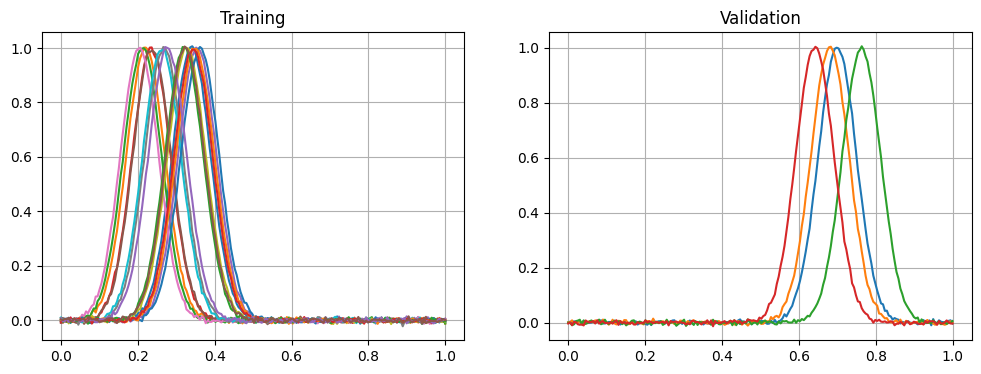

In [3]:
import matplotlib.pyplot as plt
# plot train trajectories on the left and validation trajectories on the right
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
for i in range(num_demos):
    axs[0].plot(x_train[i, :, 0], y_train[i, :, 0], label=f"Demo {i}")
for i in range(num_val):
    axs[1].plot(x_val[i, :, 0], y_val[i, :, 0], label=f"Val {i}")
axs[0].set_title("Training")
axs[1].set_title("Validation")
axs[0].grid(True)
axs[1].grid(True)
plt.show()

In [4]:
batch_size = 4

model = PEMP(input_dim=dpe, output_dim=dy, n_max=n_max, m_max=m_max, encoder_hidden_dims=[64, 64], decoder_hidden_dims=[64, 64], batch_size=batch_size, device=device)
optimizer = torch.optim.Adam(lr=3e-4, params=model.parameters())

pytorch_total_params = sum(p.numel() for p in model.parameters())
print(pytorch_total_params)

9090


In [5]:
import math

def generate_positional_encoding(length=t_steps, d_model=4):  # d_model: dimension of encoding space
    pos = torch.arange(length).unsqueeze(1)  # (length, 1)
    div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))  # (d_model/2,)
    pe = torch.zeros(length, d_model)  # (length, d_model)
    pe[:, 0::2] = torch.sin(pos * div_term)
    pe[:, 1::2] = torch.cos(pos * div_term)
    return pe

# pe = generate_positional_encoding()

# import matplotlib.pyplot as plt
# plt.imshow(pe.T)
# plt.show()

In [6]:
obs = torch.zeros((batch_size, n_max, dpe+dy), dtype=torch.float32, device=device)
tar_x = torch.zeros((batch_size, m_max, dpe), dtype=torch.float32, device=device)
tar_y = torch.zeros((batch_size, m_max, dy), dtype=torch.float32, device=device)
obs_mask = torch.zeros((batch_size, n_max), dtype=torch.bool, device=device)
tar_mask = torch.zeros((batch_size, m_max), dtype=torch.bool, device=device)

def prepare_masked_batch(t: list, traj_ids: list):
    obs.fill_(0)
    tar_x.fill_(0)
    tar_y.fill_(0)
    obs_mask.fill_(False)
    tar_mask.fill_(False)

    for i, traj_id in enumerate(traj_ids):
        traj = t[traj_id]
        pe = generate_positional_encoding(traj.shape[0], dpe)

        n = torch.randint(1, n_max, (1,)).item()
        m = torch.randint(1, m_max, (1,)).item()

        permuted_ids = torch.randperm(t_steps)
        n_ids = permuted_ids[:n]
        m_ids = permuted_ids[n:n+m]
        
        obs[i, :n, :dpe] = pe[n_ids] # PE(t)
        obs[i, :n, dpe:] = traj[n_ids]  # SM(t)
        obs_mask[i, :n] = True
        
        tar_x[i, :m] = pe[m_ids]
        tar_y[i, :m] = traj[m_ids]
        tar_mask[i, :m] = True

val_obs = torch.zeros((batch_size, n_max, dpe+dy), dtype=torch.float32, device=device)
val_tar_x = torch.zeros((batch_size, t_steps, dpe), dtype=torch.float32, device=device)
val_tar_y = torch.zeros((batch_size, t_steps, dy), dtype=torch.float32, device=device)
val_obs_mask = torch.zeros((batch_size, n_max), dtype=torch.bool, device=device)

def prepare_masked_val_batch(t: list, traj_ids: list):
    val_obs.fill_(0)
    val_tar_x.fill_(0)
    val_tar_y.fill_(0)
    val_obs_mask.fill_(False)

    for i, traj_id in enumerate(traj_ids):
        traj = t[traj_id]
        pe = generate_positional_encoding(traj.shape[0], dpe)

        n = torch.randint(1, n_max, (1,)).item()

        permuted_ids = torch.randperm(t_steps)
        n_ids = permuted_ids[:n]
        m_ids = torch.arange(t_steps)
        
        val_obs[i, :n, :dpe] = pe[n_ids]
        val_obs[i, :n, dpe:] = traj[n_ids]
        val_obs_mask[i, :n] = True
        
        val_tar_x[i] = pe
        val_tar_y[i] = traj[m_ids]

In [7]:
import time
import os

timestamp = int(time.time())
root_folder = f'../outputs/tests/simple/{str(timestamp)}/'

if not os.path.exists(root_folder):
    os.makedirs(root_folder)

if not os.path.exists(f'{root_folder}saved_models/'):
    os.makedirs(f'{root_folder}saved_models/')

if not os.path.exists(f'{root_folder}img/'):
    os.makedirs(f'{root_folder}img/')

torch.save(y_train, f'{root_folder}y.pt')

epochs = 1000000
epoch_iter = num_demos // batch_size
v_epoch_iter = num_val//batch_size
avg_loss = 0
val_per_epoch = 1000
min_val_loss = 1000000
mse_loss = torch.nn.MSELoss()

for epoch in range(epochs):
    epoch_loss = 0

    traj_ids = torch.randperm(num_demos)[:batch_size * epoch_iter].chunk(epoch_iter)

    for i in range(epoch_iter):
        prepare_masked_batch(y_train, traj_ids[i])

        optimizer.zero_grad()
        
        pred = model(obs, tar_x, obs_mask)
        loss = model.loss(pred, tar_y, tar_mask)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    if epoch % val_per_epoch == 0 and epoch > 0:
        with torch.no_grad():
            v_traj_ids = torch.randperm(num_val)[:batch_size*v_epoch_iter].chunk(v_epoch_iter)
            val_loss = 0

            for j in range(v_epoch_iter):
                prepare_masked_val_batch(y_val, v_traj_ids[j])
                pred = model.val(val_obs, val_tar_x, val_obs_mask)
                val_loss += mse_loss(pred[:, :, :model.output_dim], val_tar_y).item()
                
            if val_loss < min_val_loss:
                min_val_loss = val_loss
                print(f'New best: {min_val_loss}')
                torch.save(model.state_dict(), f'{root_folder}saved_models/pemp.pt')

    avg_loss += epoch_loss

    if epoch % 100 == 0:
        print("Epoch: {}, Loss: {}".format(epoch, avg_loss / 100))
        avg_loss = 0

Epoch: 0, Loss: 0.0232615327835083
Epoch: 100, Loss: 0.23223277408629656
Epoch: 200, Loss: -0.5881936249136924
Epoch: 300, Loss: -1.4751859595999122
Epoch: 400, Loss: -2.5899576230347154
Epoch: 500, Loss: -3.593921872898936
Epoch: 600, Loss: -4.126955459341406
Epoch: 700, Loss: -4.458533497974276
Epoch: 800, Loss: -4.097975144907832
Epoch: 900, Loss: -4.878415940478444
New best: 0.11393686383962631
Epoch: 1000, Loss: -4.84795446254313
Epoch: 1100, Loss: -4.9635110803321005
Epoch: 1200, Loss: -5.138471173346042
Epoch: 1300, Loss: -5.299841122999787
Epoch: 1400, Loss: -5.536451246440411
Epoch: 1500, Loss: -5.489063671380282
Epoch: 1600, Loss: -5.451309477537871
Epoch: 1700, Loss: -5.473673160225153
Epoch: 1800, Loss: -5.729620465636254
Epoch: 1900, Loss: -6.03522128239274
Epoch: 2000, Loss: -5.857938293665647
Epoch: 2100, Loss: -5.949611645191908
Epoch: 2200, Loss: -6.220243012011051
Epoch: 2300, Loss: -5.927588204145431
Epoch: 2400, Loss: -6.228697087466717
Epoch: 2500, Loss: -6.1787821

KeyboardInterrupt: 